In [1]:
import numpy as np                        # ndarrys for gridded data
import pandas as pd                       # DataFrames for tabular data
import matplotlib.pyplot as plt           # plotting
from scipy import stats                   # summary statistics
import math                               # trigonometry etc.
import random                             # randon numbers
from scipy.stats import norm              # Gaussian parametric distribution
import geostatspy.GSLIB as GSLIB
from ipywidgets import interactive                      # widgets and interactivity
from ipywidgets import widgets                            
from ipywidgets import Layout
from ipywidgets import Label
from ipywidgets import VBox, HBox
import os                                                 # to set current working directory 
import math                                               # basic calculations like square root
from sklearn.model_selection import train_test_split      # train and test split
from sklearn import svm                                   # support vector machine methods
from sklearn import tree                    

# tree program from scikit learn (package for machine learning)
from sklearn.metrics import mean_squared_error, r2_score  # specific measures to check our models
import pandas.plotting as pd_plot
from intake import cat                                    # data catalogue
import seaborn as sn
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
well_df = pd.read_csv('wellData.csv')
day_df = pd.read_csv('dailyData.csv')

temp_well = well_df.drop('ESP_Motor_Frequency_Rating', axis =1).copy()


In [2]:
index_day_df = day_df.set_index(["Well_ID", "AL_Key"])


In [3]:
days_to_failure = day_df.groupby(["Well_ID", "AL_Key"])["OIL"].count()
days_to_failure

Well_ID  AL_Key
0        ESP_1     298
1        ESP_2     341
4        ESP_2     320
5        ESP_1     338
6        ESP_1     583
                  ... 
353      ESP_2     455
354      ESP_1     620
361      ESP_1     477
362      ESP_1      70
         ESP_2     482
Name: OIL, Length: 165, dtype: int64

In [4]:
L30_daily_df = []
for _iter in tqdm(index_day_df.index.unique()):
    sub_df = index_day_df.loc[_iter]
    L30_daily_df.append(sub_df.tail(30))
    
L30_daily_df = pd.concat(L30_daily_df)
L30_daily_df

  0%|          | 0/165 [00:00<?, ?it/s]

/tmp/ipykernel_16046/1723267808.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  sub_df = index_day_df.loc[_iter]


OIL         GAS       WATER ARTIFICIAL_LIFT  \
Well_ID AL_Key                                                       
345     ESP_2   342.990580  594.173422  351.208567             ESP   
        ESP_2   320.258097  579.186096  317.956414             ESP   
        ESP_2   368.765764  624.923558  410.109889             ESP   
        ESP_2   324.828073  567.879093  320.114847             ESP   
        ESP_2   331.743892  602.440954  373.719175             ESP   
...                    ...         ...         ...             ...   
142     ESP_1   130.568357  335.639084  433.161488             ESP   
        ESP_1   135.061535  338.161005  421.979434             ESP   
        ESP_1   135.757477  341.732930  428.363835             ESP   
        ESP_1    64.788755  170.379740  221.002588             ESP   
        ESP_1     0.000000    0.000000    0.000000             ESP   

                DOWN_TIME_HOURS  ESP Data - Drive Current  \
Well_ID AL_Key                                              
345     ESP_2               0.0                187.133275   
        ESP_2               2.0                189.055312   
        ESP_2               0.0                187.404907   
        ESP_2               2.0                194.687078   
        ESP_2               0.0                186.879722   
...                         ...                       ...   
142     ESP_1               0.0                232.000000   
        ESP_1               0.0                232.000000   
        ESP_1               0.0                230.433113   
        ESP_1              12.0                243.458937   
        ESP_1              24.0                369.099649   

                ESP Data - Drive Voltage  ESP Data - Intake Pressure  \
Well_ID AL_Key                                                         
345     ESP_2                 376.545313                  854.548535   
        ESP_2                 377.836775                  855.526667   
        ESP_2                 374.188009                  851.166957   
        ESP_2                 376.419526                  853.931618   
        ESP_2                 377.583183                  856.324621   
...                                  ...                         ...   
142     ESP_1                 433.000000                  894.599976   
        ESP_1                 433.000000                  894.599976   
        ESP_1                 431.364779                  893.432975   
        ESP_1                 423.202102                  934.540501   
        ESP_1                 402.275272                 1527.854901   

                ESP Data - Motor Temperature Shutdown Setpoint  \
Well_ID AL_Key                                                   
345     ESP_2                                              NaN   
        ESP_2                                              NaN   
        ESP_2                                              NaN   
        ESP_2                                              NaN   
        ESP_2                                              NaN   
...                                                        ...   
142     ESP_1                                            240.0   
        ESP_1                                            240.0   
        ESP_1                                            240.0   
        ESP_1                                            240.0   
        ESP_1                                            240.0   

                ESP Data - Motor Winding Temperature  ...  \
Well_ID AL_Key                                        ...   
345     ESP_2                             185.369255  ...   
        ESP_2                             185.598807  ...   
        ESP_2                             185.382729  ...   
        ESP_2                             186.596381  ...   
        ESP_2                             185.243134  ...   
...                                              ...  ...   
142     ESP_1                     

In [ ]:
B30_daily_df = []
for _iter in tqdm(index_day_df.index.unique()):
    sub_df = index_day_df.loc[_iter]
    B30_daily_df.append(sub_df.head(30))
    
B30_daily_df = pd.concat(B30_daily_df)
B30_daily_df

In [6]:
L30_daily_df = L30_daily_df.drop(['Lower_Limit', 'Power_Difference', 'ESP Data - Motor Winding Temperature', 'Drive_Power' ], axis = 1)

In [7]:
def plot_corr(dataframe,size=10):                         # plots a graphical correlation matrix 
    corr = dataframe.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    im = ax.matshow(corr,vmin = -1.0, vmax = 1.0)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    plt.colorbar(im, orientation = 'vertical')
    plt.title('Correlation Matrix')
    
def visualize_model(model,xfeature,yfeature,response,title,):# plots the data points and the decision tree prediction 
    n_classes = 10
    cmap = plt.cm.RdYlBu
    plot_step = 0.02
    x_min, x_max = min(xfeature) - 1, max(xfeature) + 1
    y_min, y_max = min(yfeature) - 1, max(yfeature) + 1
    resp_min = round(min(response)); resp_max = round(max(response));
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))
    z_min = round(min(response)); z_max = round(max(response))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap,vmin=z_min, vmax=z_max)

    im = plt.scatter(xfeature,yfeature,s=None, c=response, marker=None, cmap=cmap, norm=None, vmin=z_min, vmax=z_max, alpha=0.8, linewidths=0.3, edgecolors="black")
    plt.title(title)
    plt.xlabel(xfeature.name)
    plt.ylabel(yfeature.name)
    cbar = plt.colorbar(im, orientation = 'vertical')
    cbar.set_label(response.name, rotation=270, labelpad=20)
    return(plt)
L30_daily_df.columns

Index(['OIL', 'GAS', 'WATER', 'ARTIFICIAL_LIFT', 'DOWN_TIME_HOURS',
       'ESP Data - Drive Current', 'ESP Data - Drive Voltage',
       'ESP Data - Intake Pressure',
       'ESP Data - Motor Temperature Shutdown Setpoint',
       'ESP Data - Output Frequency', 'ESP Data - Vibration X',
       'Startup_Count', 'Oil_Intake', 'Water_Intake', 'Gas_Intake',
       'Liquid_Intake', 'Gas_Saturation_at_Intake', 'Gas_Separator_Efficiency',
       'Gas_through_Annulus_Intake', 'Gas_through_ESP_Intake',
       'Gas_through_Annulus', 'Gas_through_ESP', 'Pb_ESP',
       'Discharge_Pressure', 'ESP_Fluid', 'Gas_Saturation_at_Discharge',
       'Pump_Delta_Pressure', 'Pump_Average_Pressure',
       'Gas_Saturation_in_Pump', 'Pump_Power', 'Power_Ratio',
       'ESP_Temperature'],
      dtype='object')

In [8]:



corr_matrix = L30_daily_df.corr()
corr_matrix

/tmp/ipykernel_16046/2137311096.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = L30_daily_df.corr()


,OIL,GAS,WATER,DOWN_TIME_HOURS,ESP Data - Drive Current,ESP Data - Drive Voltage,ESP Data - Intake Pressure,ESP Data - Motor Temperature Shutdown Setpoint,ESP Data - Output Frequency,ESP Data - Vibration X,...,Pb_ESP,Discharge_Pressure,ESP_Fluid,Gas_Saturation_at_Discharge,Pump_Delta_Pressure,Pump_Average_Pressure,Gas_Saturation_in_Pump,Pump_Power,Power_Ratio,ESP_Temperature
OIL,1.000000,0.598612,0.719677,-0.276368,0.460147,-0.058730,0.587393,0.145265,-0.170878,0.248499,...,-0.196685,0.211606,0.640531,-0.295798,-0.159021,0.469047,-0.405278,0.614408,0.497063,-0.065665
GAS,0.598612,1.000000,0.482119,-0.366192,0.219077,0.077147,0.380475,0.035613,0.068733,0.024124,...,0.279628,-0.096427,0.747226,0.019930,-0.342018,0.170031,0.126160,0.461106,0.403976,-0.029634
WATER,0.719677,0.482119,1.000000,-0.276742,0.486811,-0.071027,0.548818,0.093082,-0.183365,0.233071,...,-0.094704,0.431388,0.588828,-0.328626,0.056674,0.623243,-0.441695,0.747494,0.657088,-0.272772
DOWN_TIME_HOURS,-0.276368,-0.366192,-0.276742,1.000000,-0.005223,-0.025290,0.047212,-0.066009,-0.111408,-0.035183,...,0.032547,0.050664,-0.206859,0.001458,0.018663,-0.066067,0.008689,-0.226059,-0.284267,0.147717
ESP Data - Drive Current,0.460147,0.219077,0.486811,-0.005223,1.000000,0.397545,0.216535,0.114289,0.036298,0.248675,...,-0.154745,0.246502,0.306931,-0.241345,0.079674,0.329348,-0.306944,0.518627,0.200176,-0.020716
ESP Data - Drive Voltage,-0.058730,0.077147,-0.071027,-0.025290,0.397545,1.000000,-0.159846,0.079307,0.484271,-0.026164,...,0.088813,-0.143216,-0.020221,0.023721,-0.050079,-0.121777,0.117950,0.007599,-0.123335,0.018270
ESP Data - Intake Pressure,0.587393,0.380475,0.548818,0.047212,0.216535,-0.159846,1.000000,0.039521,-0.305785,0.039874,...,0.200896,0.131857,0.445744,-0.060264,-0.445986,0.443309,-0.176394,0.170578,0.129467,0.056085
ESP Data - Motor Temperature Shutdown Setpoint,0.145265,0.035613,0.093082,-0.066009,0.114289,0.079307,0.039521,1.000000,0.059703,-0.106486,...,-0.109387,0.009732,0.038144,-0.151349,-0.021168,0.049996,-0.181159,0.061599,0.030062,0.111562
ESP Data - Output Frequency,-0.170878,0.068733,-0.183365,-0.111408,0.036298,0.484271,-0.305785,0.059703,1.000000,0.062385,...,0.004025,-0.135025,0.023219,0.172344,0.046057,-0.227472,0.219145,0.106743,-0.063117,0.022200
ESP Data - Vibration X,0.248499,0.024124,0.233071,-0.035183,0.248675,-0.026164,0.039874,-0.106486,0.062385,1.000000,...,-0.130414,0.035148,0.162684,-0.049661,0.007477,0.047099,-0.103484,0.316185,0.180998,-0.036957


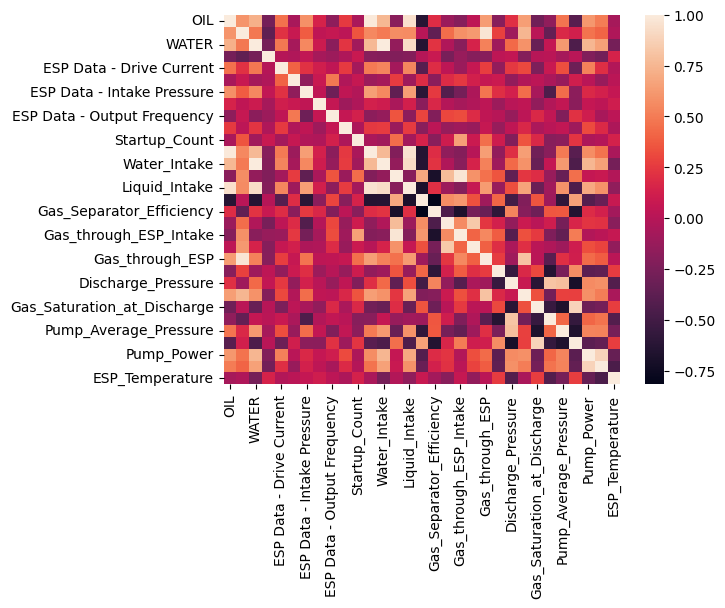

In [9]:
sn.heatmap(corr_matrix, annot=False)
plt.show()

In [ ]:
pd_plot.scatter_matrix(L30_daily_df, alpha = 0.1,              # pandas matrix scatter plot
    figsize=(10, 10),color = 'black', hist_kwds={'color':['grey']})
plt.show()